In [11]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})


In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [5]:
SAVE_DIR_FIG3 = Path(SAVE_DIR) / "figure3"
SAVE_DIR_FIG3.mkdir(parents=True, exist_ok=True)

In [51]:
import math

def plot_brain_state_effects(main_analysis):
    """Create figure showing content feature effects split by group
    
    Parameters:
    -----------
    main_analysis : numpy.ndarray
        Array containing the analysis results data structure
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure with brain state effects plots
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Convert numpy array to dictionary
    results_dict = main_analysis.item()
    
    # Get features from the feature_results dictionary
    features = list(results_dict['feature_results'].keys())
    
    # Sort features consistently to ensure y-axis labels remain fixed across different results
    # Default to alphabetical sorting if no specific order is provided
    plot_features = sorted(features)
    
    # Reference group (Affair)
    affair_data = {
        'feature': plot_features,
        'coefficient': [results_dict['feature_results'][f]['coefficients']['group'] 
                       for f in plot_features],
        'pvalue': [results_dict['feature_results'][f]['prob_nonzero']['group'] 
                  for f in plot_features],
        'ci_lower': [results_dict['feature_results'][f]['conf_int']['group']['lower']
                    for f in plot_features],
        'ci_upper': [results_dict['feature_results'][f]['conf_int']['group']['upper']
                    for f in plot_features]
    }
    
    # Paranoia group (base + interaction)
    paranoia_data = {
        'feature': plot_features,
        'coefficient': [results_dict['feature_results'][f]['coefficients']['group'] +
                       results_dict['feature_results'][f]['coefficients']['interaction']
                       for f in plot_features],
        'pvalue': [results_dict['feature_results'][f]['prob_nonzero']['interaction'] 
                  for f in plot_features],
        'ci_lower': [results_dict['feature_results'][f]['conf_int']['group']['lower'] +
                    results_dict['feature_results'][f]['conf_int']['interaction']['lower']
                    for f in plot_features],
        'ci_upper': [results_dict['feature_results'][f]['conf_int']['group']['upper'] +
                    results_dict['feature_results'][f]['conf_int']['interaction']['upper']
                    for f in plot_features]
    }
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    def plot_group(ax, df, title, group_color):
        # Define non-significant color
        ns_color = '#666666'
        
        # Determine significance based on both p-value and CI
        colors = []
        significance = []
        for _, row in df.iterrows():
            # Check if CI excludes zero and p < 0.05
            is_significant = (not (row['ci_lower'] <= 0 <= row['ci_upper'])) and (row['pvalue'] < 0.05)
            colors.append(group_color if is_significant else ns_color)
            
            # Store significance level
            if not (row['ci_lower'] <= 0 <= row['ci_upper']):
                if row['pvalue'] < 0.001:
                    significance.append('***')
                elif row['pvalue'] < 0.01:
                    significance.append('**')
                elif row['pvalue'] < 0.05:
                    significance.append('*')
                else:
                    significance.append('')
            else:
                significance.append('')
        
        # Get number of features for y-axis range
        n_features = len(df)
        
        # Determine appropriate x-axis range based on data
        all_values = list(df['coefficient']) + list(df['ci_lower']) + list(df['ci_upper'])
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Add padding to the range
        range_padding = 0.1
        x_min = min(min_val - range_padding, -range_padding)  # Ensure we include 0
        x_max = max(max_val + range_padding, range_padding)   # Ensure we include 0
        
        # Create reasonable tick spacing
        tick_count = 9  # Aim for about 9 ticks
        tick_step = round((x_max - x_min) / (tick_count - 1), 1)  # Round to 1 decimal place
        
        # Generate ticks, ensuring 0 is included
        ticks = []
        current = math.floor(x_min / tick_step) * tick_step  # Start at a nice round number
        while current <= x_max:
            ticks.append(current)
            current += tick_step
            
        # Ensure 0 is in the ticks if it's in range
        if x_min <= 0 <= x_max and 0 not in ticks:
            ticks.append(0)
            ticks.sort()
            
        # # Add reference lines for important values
        # for coef in ticks:
        #     alpha = 1.0 if coef == 0 else 0.2
        #     style = '--' if coef == 0 else ':'
        #     ax.axvline(x=coef, color='gray', alpha=alpha, linestyle=style)
            
        #     # Add odds ratio labels for a few key values
        #     if coef != 0 and abs(coef) >= 0.2:  # Only label major ticks
        #         odds_ratio = np.exp(coef)
        #         # Only show "OR=" for the first negative and first positive labeled value
        #         positive_ticks = [t for t in ticks if t >= 0.2]
        #         negative_ticks = [t for t in ticks if t <= -0.2]
                
        #         if positive_ticks and coef == min(positive_ticks):
        #             label = f"OR={odds_ratio:.2f}"
        #         elif negative_ticks and coef == max(negative_ticks):
        #             label = f"OR={odds_ratio:.2f}"
        #         else:
        #             label = f"{odds_ratio:.2f}"
        #         ax.text(coef, n_features + 0.5, label, 
        #                ha='center', va='bottom', alpha=0.8, fontsize=8)
                       
        # # Set custom x-ticks
        ax.set_xticks(ticks)
        ax.set_xlim(x_min, x_max)
        
        # Plot coefficients
        y_pos = np.arange(len(df))
        ax.scatter(df['coefficient'], y_pos, c=colors, s=100)
        
        # Add error bars
        for i, (_, row) in enumerate(df.iterrows()):
            ax.hlines(y_pos[i], row['ci_lower'], row['ci_upper'], 
                     color=colors[i], alpha=0.5, linewidth=2)
        
        # Customize plot
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f.replace('_', ' ').title() for f in df['feature']], fontsize=10)
        ax.set_xlabel('Log Odds Coefficient (β)', fontsize=12)
        ax.set_title(title, fontsize=14)
        
        # Add significance markers
        fixed_offset = 0.05  # Fixed distance for significance markers
        
        for i, sig in enumerate(significance):
            if sig:
                # For negative effects, put markers on the left
                if df.iloc[i]['ci_upper'] < 0:
                    ax.text(df.iloc[i]['ci_lower'] - fixed_offset, i, sig, 
                           ha='right', va='center', fontsize=12)
                # For positive effects, put markers on the right
                else:
                    ax.text(df.iloc[i]['ci_upper'] + fixed_offset, i, sig, 
                           ha='left', va='center', fontsize=12)
                           
        # Extend y-axis limits to make room for OR labels
        ax.set_ylim(-0.5, n_features + 1)
        
        # Add legend
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=group_color,
                  label='p < 0.05', markersize=10),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=ns_color,
                  label='n.s.', markersize=10)
        ]
        ax.legend(handles=legend_elements, loc='lower right')
    
    # Create plots using COLORS dictionary
    plot_group(ax1, df_affair, 'Affair Group Effects', COLORS['affair'])
    plot_group(ax2, df_paranoia, 'Paranoia Group Effects', COLORS['paranoia'])
    
    plt.tight_layout()
    return fig

In [27]:
state_map = {"affair_to_paranoia": {0:1, 1:2, 2:0}, "paranoia_to_affair": {1:0, 2:1, 0:2}}

In [13]:
def get_brain_content_data(state_affair, state_paranoia):
    # Use Path.glob() method instead of glob module
    pattern = f'hierarchical_analysis_results_*.npz'
    search_path = Path(OUTPUT_DIR) / '11_brain_content_analysis' / f'state_affair_{state_affair}_state_paranoia_{state_paranoia}'
    brain_content_path = list(search_path.glob(pattern))[0]
    brain_content_data = np.load(brain_content_path, allow_pickle=True)
    meta_data = brain_content_data['metadata']
    main_analysis = brain_content_data['main_analysis']
    cross_validation = brain_content_data['cross_validation']
    return meta_data, main_analysis, cross_validation

In [14]:
state_affair = 0
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a0p1 , main_analysis_a0p1, cross_validation_a0p1 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 1
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a1p2, main_analysis_a1p2, cross_validation_a1p2 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 2
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a2p0, main_analysis_a2p0, cross_validation_a2p0 = get_brain_content_data(state_affair, state_paranoia)

In [16]:
main_analysis_a2p0

array({'feature_results': {'lee_girl_together': {'coefficients': {'const': -0.8171601107762223, 'feature': 0.17761942552945048, 'group': -0.15661203814560418, 'interaction': -0.11559991884835936}, 'posterior_sds': {'const': 0.1051216341217442, 'feature': 0.10701076211858725, 'group': 0.03490907844464249, 'interaction': 0.1546290534505052}, 'z_scores': {'const': -7.773472298098478, 'feature': 1.6598276847389992, 'group': -4.486283944560544, 'interaction': -0.7475950752383117}, 'prob_nonzero': {'const': 7.549516567451064e-15, 'feature': 0.09694912262426936, 'group': 7.247613965644106e-06, 'interaction': 0.4547044361339774}, 'conf_int': {'const': {'lower': -1.023198513654841, 'upper': -0.6111217078976037}, 'feature': {'lower': -0.032121668222980515, 'upper': 0.3873605192818815}, 'group': {'lower': -0.22503383189710346, 'upper': -0.08819024439410489}, 'interaction': {'lower': -0.41867286361134953, 'upper': 0.18747302591463083}}, 'model_summary': '                Binomial Mixed GLM Results\

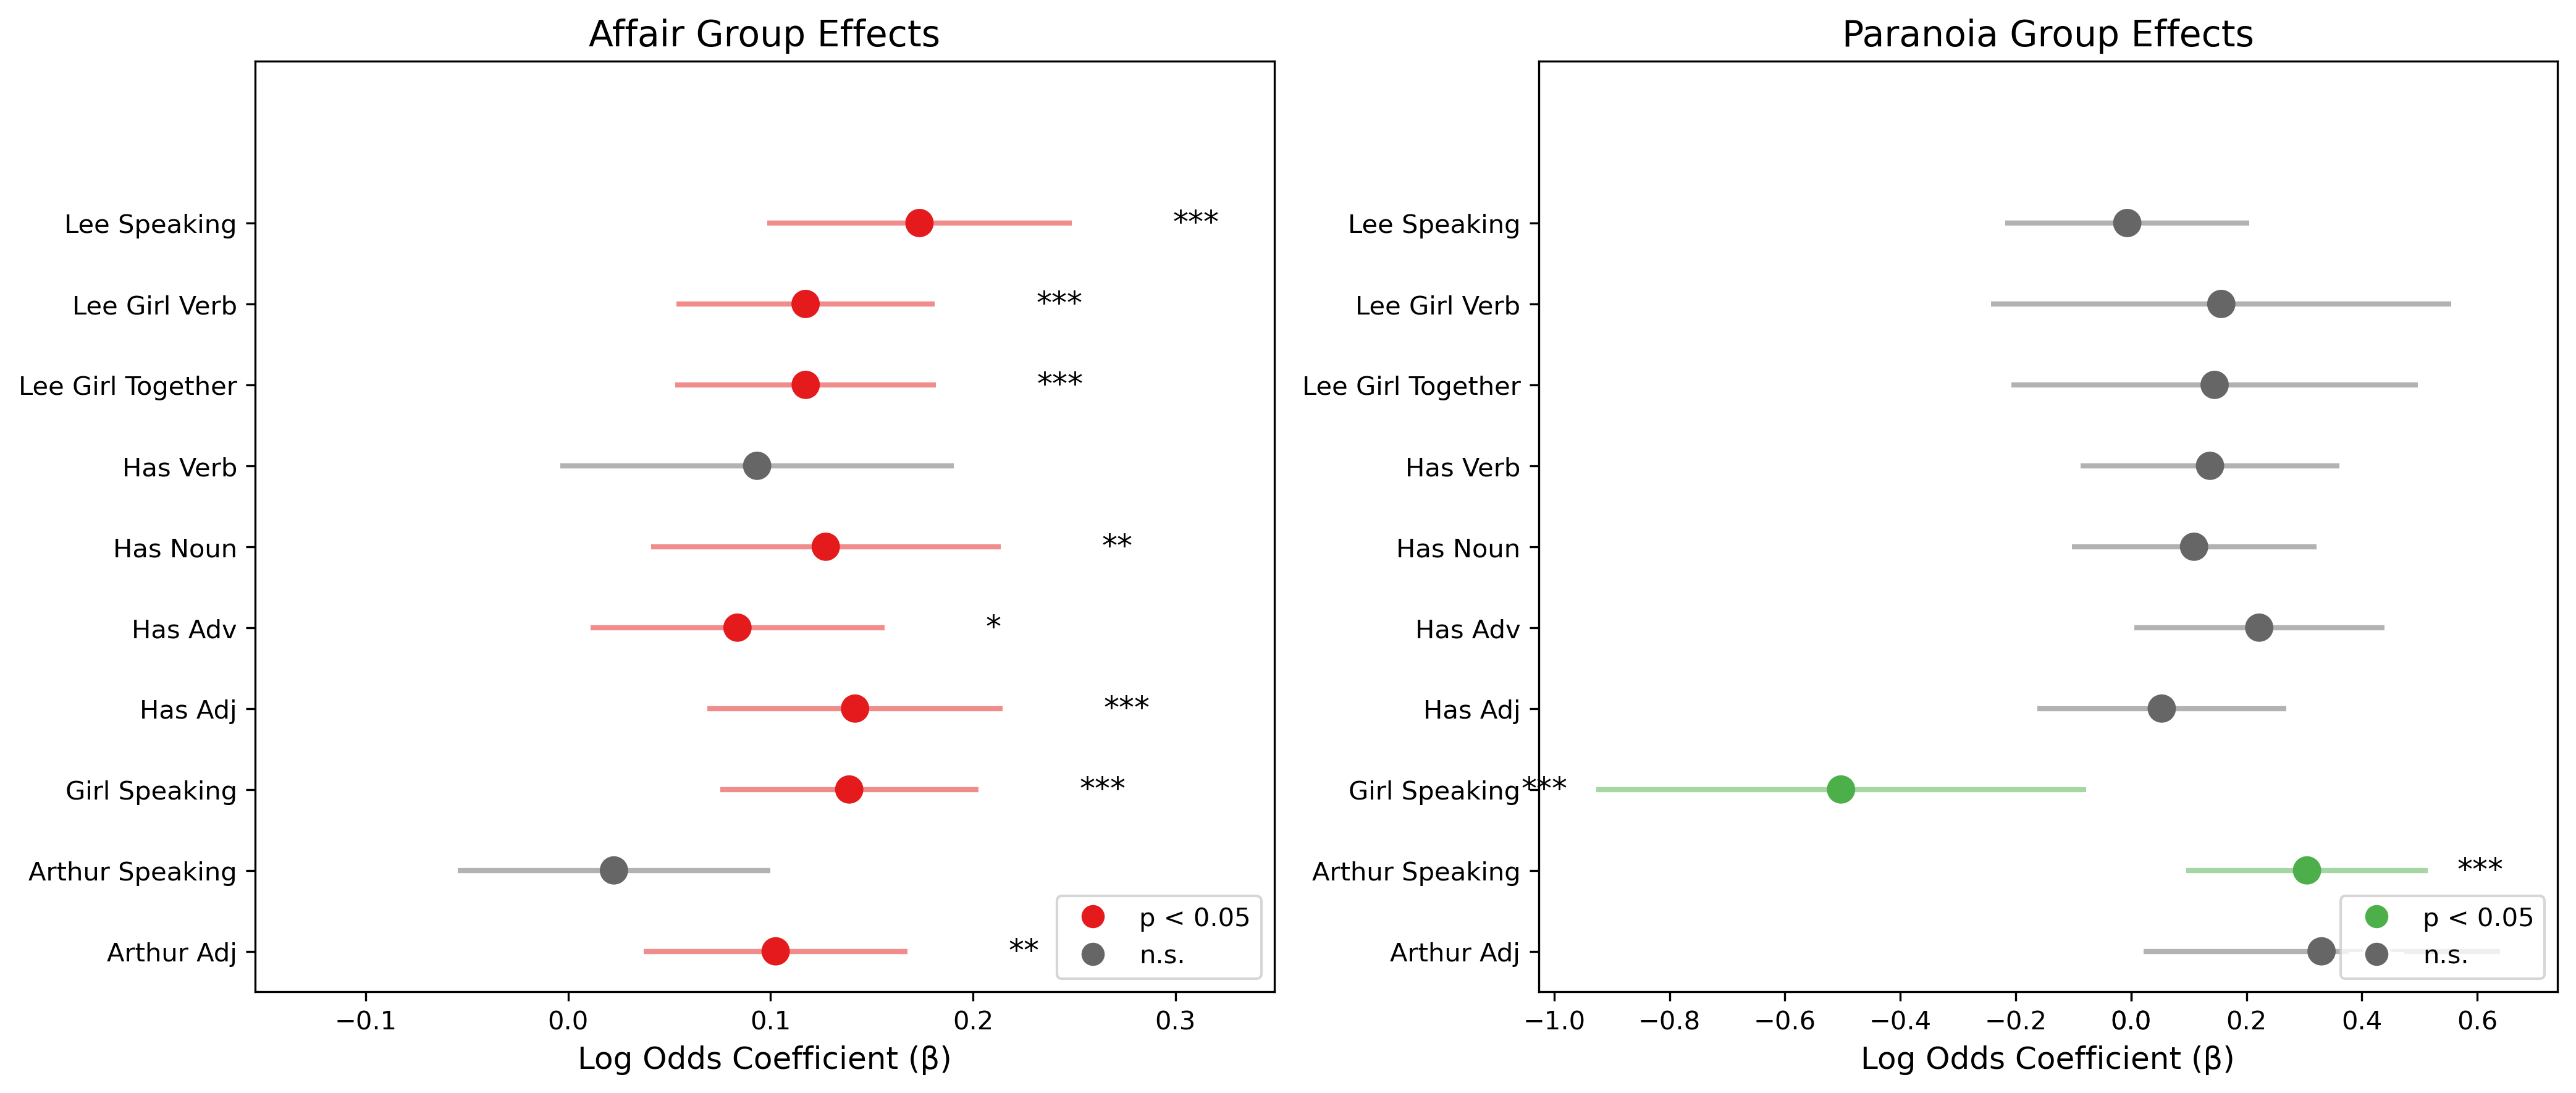

In [52]:
plot_brain_state_effects(main_analysis_a0p1)

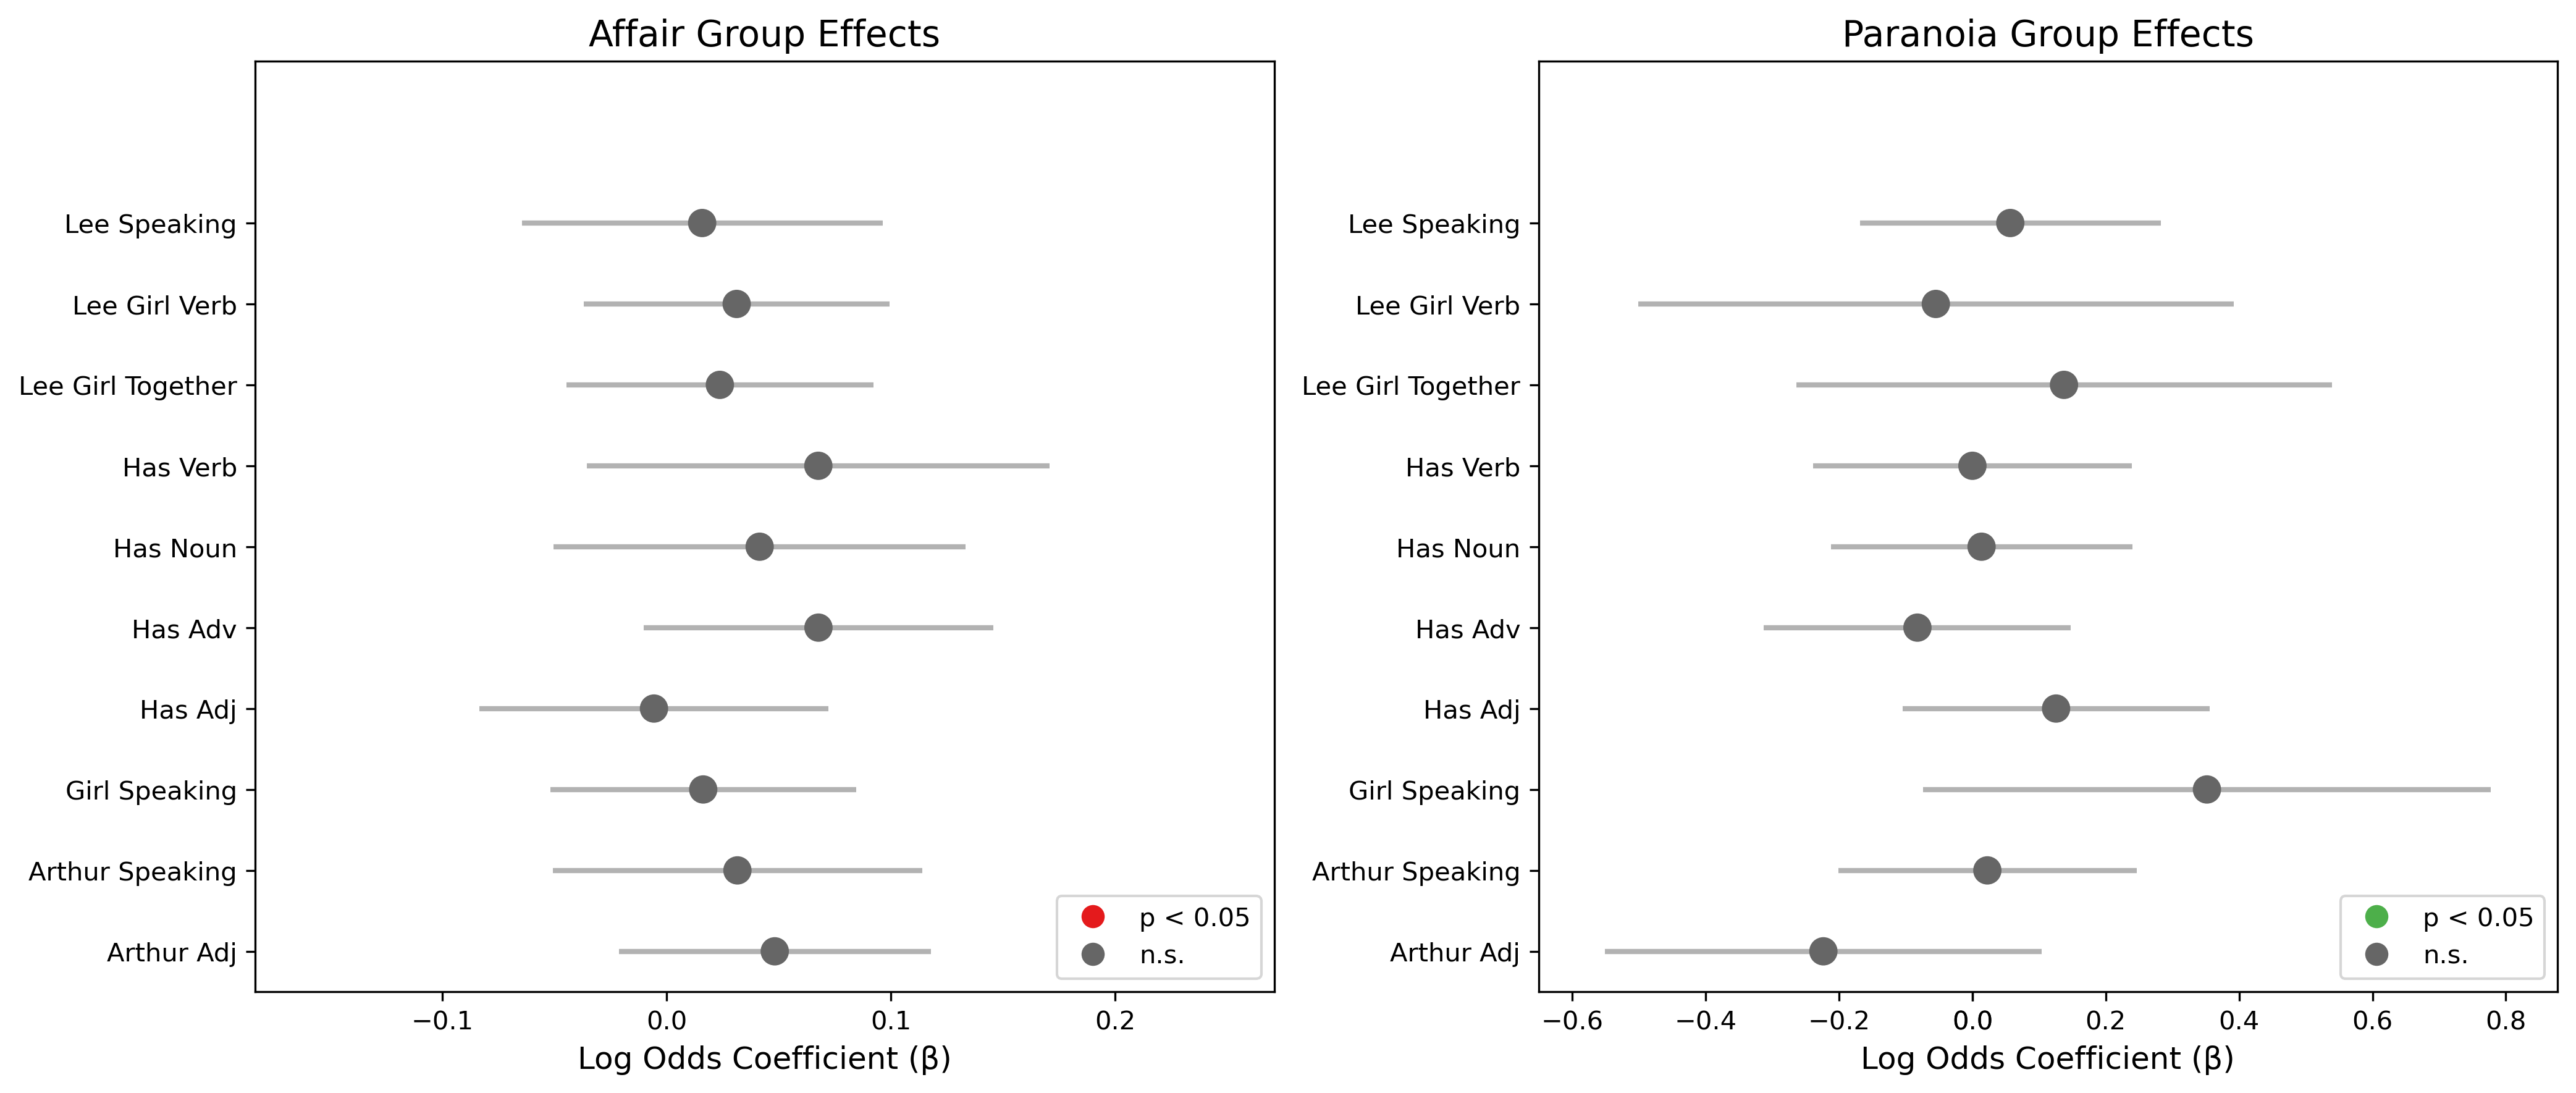

In [53]:
plot_brain_state_effects(main_analysis_a1p2)

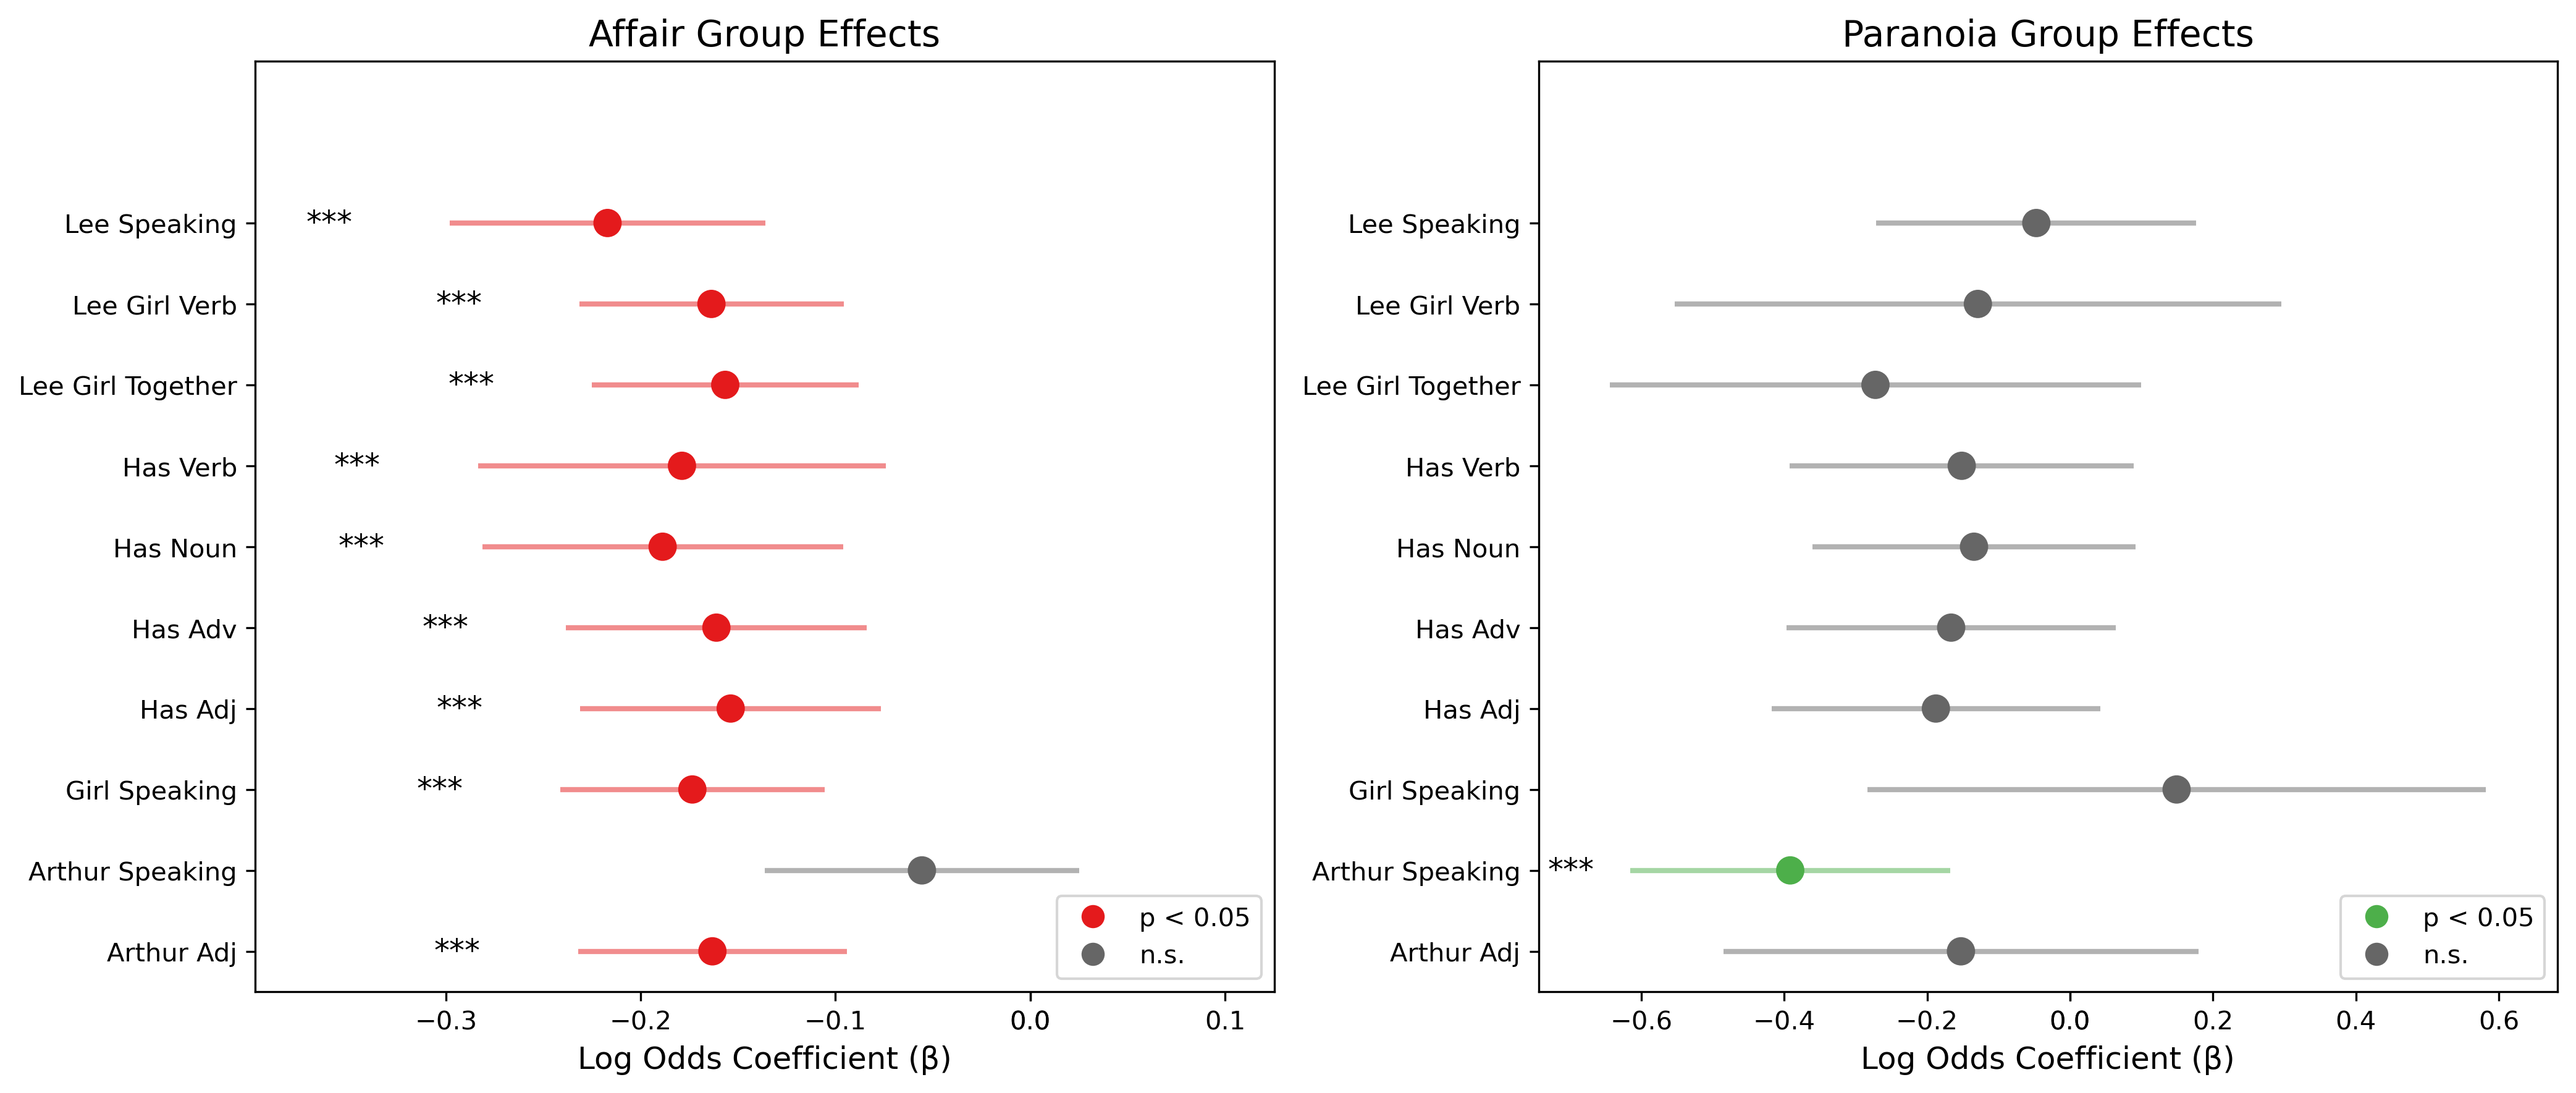

In [54]:
plot_brain_state_effects(main_analysis_a2p0)